In [1]:
import Batched_GNN_2 as network

import numpy as np
import pandas as pd
import pickle

import torch
import torch.optim as optim
import torch.nn as nn

from collections import Counter
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

In [2]:
# PICKLE IN THE TRAIN AND TEST DATA
with open('Training_data/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('Training_data/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('Training_data/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('Training_data/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

with open('global_graph.pkl', 'rb') as f:
    global_graph = pickle.load(f)

In [3]:
model = network.GNNClassifier(num_classes=11, global_graph=global_graph)

In [4]:
print(len(y_train))

11476


In [5]:
# CLASS FREQUENCY NORMALIZATION FOR TRAINING

# Should only be done on y_train
c = Counter(y_train)
class_counts = np.array([c[0], c[1], c[2], c[3], c[4], c[5], c[6], c[7], c[8], c[9], c[10]])
total_samples = sum(class_counts)

# Compute weights: Inverse class frequency
weights = total_samples / (len(class_counts) * class_counts) # + 1e1)
weights = torch.tensor(weights, dtype=torch.float32)

# Ensure it sums to 1 (optional normalization)
weights /= weights.sum()
weights



# Compute class weights (inverse frequency)
sample_weights = [weights[label] for label in y_train]  # dataset_labels = ground truth labels

# Convert to tensor
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

# Create a sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Use sampler in DataLoader
train_loader = DataLoader(X_train, batch_size=64, sampler=sampler)
test_loader  = DataLoader(X_test , batch_size=1)

In [6]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test , dtype=torch.long)

In [7]:
print(class_counts)
print(weights)
weights = weights ** 0.2
print(weights)

# no epsilon
# [5944 2819  967  603  780  215   93   40    7    3    5] (+ 0 for weight calcs)
# tensor([2.3331e-04, 4.9194e-04, 1.4341e-03, 2.2998e-03, 1.7779e-03, 6.4502e-03,
#         1.4912e-02, 3.4670e-02, 1.9811e-01, 4.6226e-01, 2.7736e-01])

# epsolon = 50
# [5944 2819  967  603  780  215   93   40    7    3    5] (+ 50 for weight calcs)
# tensor([0.0005, 0.0010, 0.0028, 0.0045, 0.0035, 0.0125, 0.0280, 0.0614, 0.2369,
#         0.3625, 0.2865])

# epsolon = 100
# [5944 2819  967  603  780  215   93   40    7    3    5] (+ 100 for weight calcs)
# tensor([0.0007, 0.0014, 0.0040, 0.0064, 0.0050, 0.0175, 0.0384, 0.0799, 0.2438,
#         0.3245, 0.2784])

[5944 2819  967  603  780  215   93   40    7    3    5]
tensor([2.3331e-04, 4.9194e-04, 1.4341e-03, 2.2998e-03, 1.7779e-03, 6.4502e-03,
        1.4912e-02, 3.4670e-02, 1.9811e-01, 4.6226e-01, 2.7736e-01])
tensor([0.1878, 0.2180, 0.2700, 0.2967, 0.2818, 0.3647, 0.4312, 0.5105, 0.7234,
        0.8570, 0.7738])


In [8]:
# Loss function and optimizer
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() #weight=weights) #, label_smoothing=0.1)
# weight=weights does push average predictions to the right, but way too far / extremely
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-4)
num_epochs = 35

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    index = 0
    for X_batch in train_loader:
        debug = False
        if debug:
            torch.autograd.set_detect_anomaly(True)
            print('batch shape:', X_batch)
            #print(X_batch.x[0])
            if index >= 10:
                raise
        
        index += 1
        optimizer.zero_grad()           # Zero the gradients
        output = model(X_batch)               # Forward pass
        loss = criterion(output, X_batch.y)     # Compute loss
        running_loss += loss.item()
        old_params = [p.clone() for p in model.parameters()]
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights

        debug = False
        if debug:
            print(X_batch)
            print(X_batch.x[0])
            print(loss)
            for i, p in enumerate(model.parameters()):
                change = (p - old_params[i]).abs().sum()
                print(f"Parameter {i} changed by {change.item()}")
            if index >= 10:
                raise
    
    epoch_loss = running_loss / len(train_loader)


    # test_loss = 0.0
    # total_samples = 0
    # with torch.no_grad():
    #     for X_batch, y_batch in test_loader:
    #         output = model(X_batch)
    #         loss = criterion(output, y_batch)
    #         test_loss += loss.item() * X_batch.size(0)
    #         total_samples += X_batch.size(0)
    # avg_test_loss = test_loss / total_samples

    
    # Evaluate on the test set
    model.eval()
    correct = 0
    correct_leeway = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for X, y in zip(X_test, y_test):
            #batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(X)
            loss = criterion(output, y.unsqueeze(dim=0))
            test_loss += loss.item() #* batch_X.size(0)
            # Compute predictions
            _, predicted = torch.max(output.data, 1)
            total += 1 #batch_y.size(0)
            # correct exactly
            correct += (predicted == y) #(predicted == batch_y).sum().item()
            # correct with 1 leeway
            p1 = (predicted >= y-1)
            p2 = (predicted <= y+1)
            correct_leeway += (p1*p2)
            
            
    epoch_test_loss = test_loss / len(y_test)
    accuracy = correct / total * 100
    accuracy_leeway = correct_leeway / total * 100
    
    correct = 0
    correct_leeway = 0
    total = 0
    with torch.no_grad():
        for X, y in zip(X_train, y_train):
            #batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(X)
            # Compute predictions
            _, predicted = torch.max(output.data, 1)
            total += 1 #batch_y.size(0)
            # correct exactly
            correct += (predicted == y) #(predicted == batch_y).sum().item()
            # correct with 1 leeway
            p1 = (predicted >= y-1)
            p2 = (predicted <= y+1)
            correct_leeway += (p1*p2)
            
    train_accuracy = correct / total * 100
    train_accuracy_leeway = correct_leeway / total * 100
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, "
          f"Train Accuracy: {train_accuracy}%, "
          f"Test Accuracy: {accuracy}%, \n"
          f"Train Accuracy w leeway: {train_accuracy_leeway}%, "
          f"Test Accuracy w leeway: {accuracy_leeway}% \n"
            )
    
### TRY TEST ACCURACY WITH A 1 GRADE LEEWAY
### EVENTUALLY, CAN TRY TESTING WITH 1 UP OR DOWN LEEWAY ACCORDING TO WHETHER USER/SETTER GRADE IS SOFT OR HARD

Epoch [1/35], Train Loss: 1.8571, Test Loss: 1.7889, Train Accuracy: tensor([36.3716])%, Test Accuracy: tensor([37.2822])%, 
Train Accuracy w leeway: tensor([59.5765])%, Test Accuracy w leeway: tensor([60.1394])% 

Epoch [2/35], Train Loss: 1.2425, Test Loss: 1.1469, Train Accuracy: tensor([55.9690])%, Test Accuracy: tensor([54.5645])%, 
Train Accuracy w leeway: tensor([83.6790])%, Test Accuracy w leeway: tensor([82.6481])% 

Epoch [3/35], Train Loss: 1.1118, Test Loss: 1.2064, Train Accuracy: tensor([53.7470])%, Test Accuracy: tensor([51.6376])%, 
Train Accuracy w leeway: tensor([86.3106])%, Test Accuracy w leeway: tensor([85.2265])% 

Epoch [4/35], Train Loss: 1.0324, Test Loss: 1.1404, Train Accuracy: tensor([55.4374])%, Test Accuracy: tensor([54.4251])%, 
Train Accuracy w leeway: tensor([86.9990])%, Test Accuracy w leeway: tensor([87.1429])% 

Epoch [5/35], Train Loss: 0.9931, Test Loss: 1.0625, Train Accuracy: tensor([59.2977])%, Test Accuracy: tensor([57.2474])%, 
Train Accuracy 

In [9]:
model(X_train[700]), model(X_train[2]), model(X_train[0])

(tensor([[ 15.8396,  14.2802,  11.0334,   8.6276,   5.8461,  -5.0222, -28.8577,
          -27.2489, -28.7461, -12.7673, -10.9360]], grad_fn=<AddmmBackward0>),
 tensor([[ 11.0671,  11.1987,   9.6619,   8.3240,   5.2853,  -4.0354, -22.0237,
          -25.4633, -26.5290, -11.5083, -11.0778]], grad_fn=<AddmmBackward0>),
 tensor([[ -2.9795,   1.6638,   4.3218,   5.2530,   4.9786,   5.2369,  -0.3540,
          -18.9862, -17.9028, -11.0075, -24.1690]], grad_fn=<AddmmBackward0>))

In [10]:
model(X_test[69]), model(X_test[223])

(tensor([[ 12.8450,  12.1293,  10.1460,   8.0414,   5.4223,  -4.0592, -17.7999,
          -30.6891, -28.9954, -14.1339, -13.1593]], grad_fn=<AddmmBackward0>),
 tensor([[ -1.1648,   2.7790,   5.3775,   6.3875,   5.2648,   1.4144, -11.0955,
          -13.8568, -22.4701,  -4.8334, -18.3271]], grad_fn=<AddmmBackward0>))

In [11]:
for name, param in model.named_parameters():
    print(f"{name}: mean={param.data.mean().item()}, std={param.data.std().item()}")

position_embedding_1.weight: mean=0.17992568016052246, std=0.30065056681632996
position_embedding_2.weight: mean=-0.004114579875022173, std=0.159599170088768
position_embedding_2.bias: mean=-0.0037732133641839027, std=0.06822439283132553
hold_type_one_hot_embedding.weight: mean=-0.013255086727440357, std=0.3837074041366577
hold_type_one_hot_embedding.bias: mean=0.020600829273462296, std=0.24143525958061218
orientation_one_hot_embedding.weight: mean=0.06444753706455231, std=0.3368108570575714
orientation_one_hot_embedding.bias: mean=0.009251207113265991, std=0.18405918776988983
coordinate_embedding.weight: mean=0.02744048833847046, std=0.31370824575424194
coordinate_embedding.bias: mean=0.06596551835536957, std=0.4697762727737427
edge_weights_1.weight: mean=0.0013568332651630044, std=0.11134414374828339
edge_weights_1.bias: mean=-0.0458131805062294, std=0.08315674215555191
edge_weights_2.weight: mean=0.0900564193725586, std=0.38002416491508484
edge_weights_2.bias: mean=0.019032530486583

/var/folders/67/6rndgtn93xq0rj_s0svwgnnh0000gp/T/ipykernel_78300/2261036337.py:2: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  print(f"{name}: mean={param.data.mean().item()}, std={param.data.std().item()}")


In [12]:
model(X_train[5]), y_train[5]
for i in range(50):
    print(model(X_train[i]), y_train[i])

tensor([[ -2.9795,   1.6638,   4.3218,   5.2530,   4.9786,   5.2369,  -0.3540,
         -18.9862, -17.9028, -11.0075, -24.1690]], grad_fn=<AddmmBackward0>) tensor(5)
tensor([[ 10.6152,  10.5127,   9.1279,   7.6885,   5.1632,  -2.8514, -21.9321,
         -24.4998, -24.2461, -12.0421,  -8.6317]], grad_fn=<AddmmBackward0>) tensor(0)
tensor([[ 11.0671,  11.1987,   9.6619,   8.3240,   5.2853,  -4.0354, -22.0237,
         -25.4633, -26.5290, -11.5083, -11.0778]], grad_fn=<AddmmBackward0>) tensor(1)
tensor([[  2.4685,   4.5730,   5.2877,   4.9502,   4.0011,  -0.4328, -11.7547,
          -9.0498, -27.8206, -14.4380,  -3.8801]], grad_fn=<AddmmBackward0>) tensor(2)
tensor([[  8.8169,   9.4286,   8.7461,   7.3476,   5.5502,  -1.9322, -22.4120,
         -23.5420, -21.5906,  -9.2605, -11.1738]], grad_fn=<AddmmBackward0>) tensor(1)
tensor([[ -3.6241,   1.5774,   4.7404,   5.7892,   6.6412,   3.2324,  -7.9993,
          -5.7027, -20.0197, -13.0221, -25.4303]], grad_fn=<AddmmBackward0>) tensor(3)
tens

In [13]:
# for b in test_loader:
#     print(b)
#     print(b.x)
#     print(b.edge_index)
#     print(b.x[b.edge_index[0]])
#     raise

In [14]:
right      = []
wrong_pred = []
wrong_true = []

right_lee  = []
wrong_leep = []
wrong_leet = []

all_x_pred = []
all_test_y = []

inc = 4
model.eval()
with torch.no_grad():
    for c in test_loader:
        pred = model(c).data
        magnitude, index = torch.max(pred, 1)
        all_x_pred.append(int(index) + inc)
        all_test_y.append(int(c.y) + inc)
        if index == c.y:
            right.append(int(index) + inc)
        else:
            wrong_pred.append(int(index) + inc)
            wrong_true.append(int(c.y)   + inc)
        if (index >= c.y-1) and (index <= c.y+1):
            right_lee.append(int(index) + inc)
        else:
            wrong_leep.append(int(index) + inc)
            wrong_leet.append(int(c.y)   + inc)
        #print(index, c.y)
        

        # loss = criterion(output, y.unsqueeze(dim=0))
        #     test_loss += loss.item() #* batch_X.size(0)
        #     # Compute predictions
        #     _, predicted = torch.max(output.data, 1)

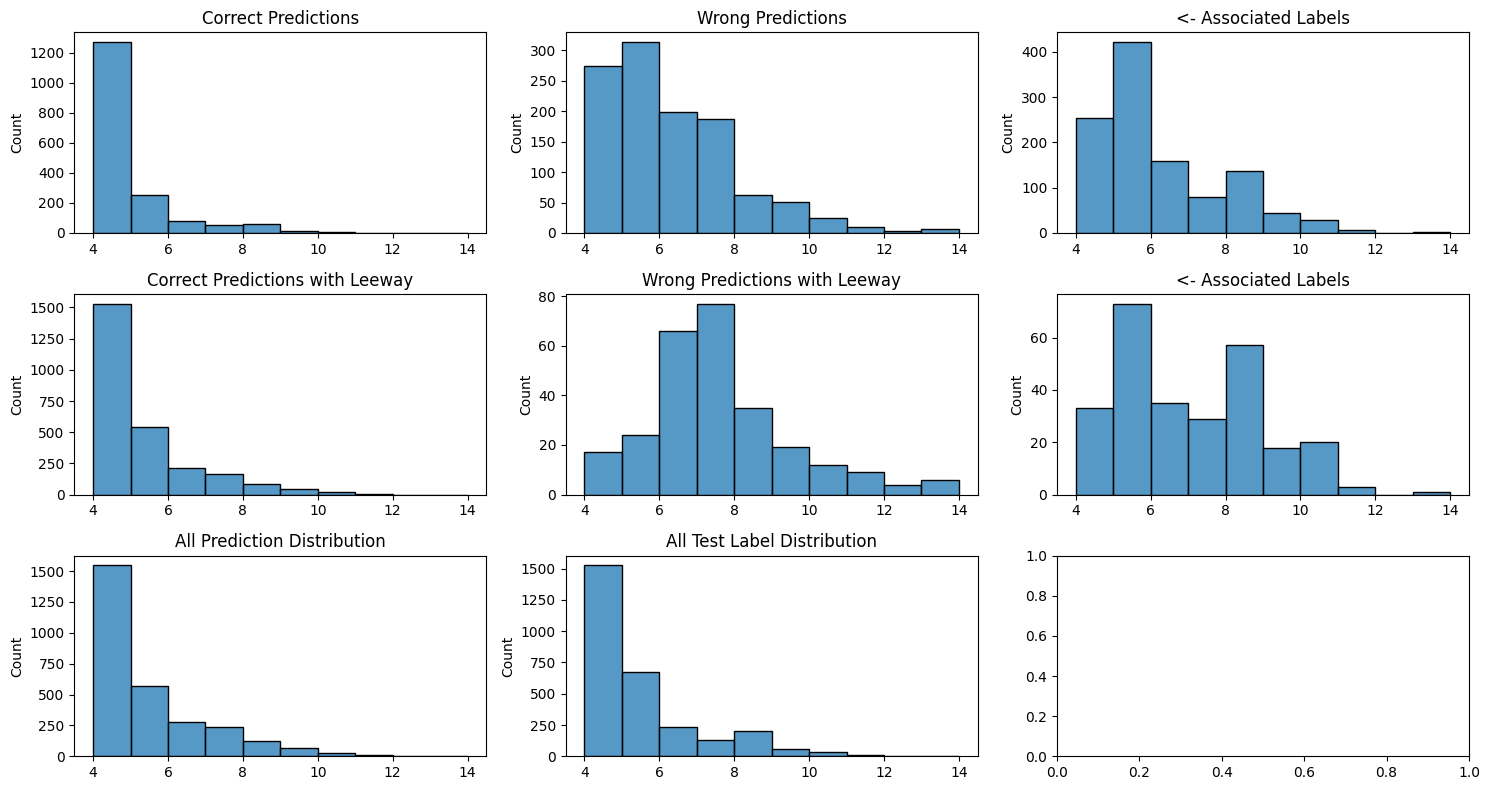

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
axes_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
#axes = axes.flatten()

sns.histplot(x = right     , bins = axes_list, ax = axes[0,0])
axes[0,0].set_title("Correct Predictions")

sns.histplot(x = wrong_pred, bins = axes_list, ax = axes[0,1])
axes[0,1].set_title("Wrong Predictions")

sns.histplot(x = wrong_true, bins = axes_list, ax = axes[0,2])
axes[0,2].set_title("<- Associated Labels")

sns.histplot(x = right_lee, bins = axes_list, ax = axes[1,0])
axes[1,0].set_title("Correct Predictions with Leeway")

sns.histplot(x = wrong_leep, bins = axes_list, ax = axes[1,1])
axes[1,1].set_title("Wrong Predictions with Leeway")

sns.histplot(x = wrong_leet, bins = axes_list, ax = axes[1,2])
axes[1,2].set_title("<- Associated Labels")

sns.histplot(x = all_x_pred, bins = axes_list, ax = axes[2,0])
axes[2,0].set_title("All Prediction Distribution")

sns.histplot(x = all_test_y, bins = axes_list, ax = axes[2,1])
axes[2,1].set_title("All Test Label Distribution")

#axes[1,1].set_visible(False)

plt.tight_layout()
plt.show()